In [1]:
import jax.numpy as jnp
import numpy as np
import jax.random as random

from data import random_walk

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from natsort import natsorted
from matplotlib.gridspec import GridSpec
import jax
from deepymod.analysis import load_tensorboard

from functools import partial
jax.config.update('jax_platform_name', 'cpu') # to fix weird memory bug

In [2]:
# settings
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-paper')
sns.set(style='white', context='paper')
col_width = 5.5 # neurips style column width in inches
plt.rcParams.update({'font.size': 7})
label_size = 8

In [3]:
df = load_tensorboard('runs/May27_21-26-17_workstationgj/')
p = jnp.load('final/inferred_density.npy')

In [4]:
prior_keys = natsorted([key for key in df.keys() if key.find('alpha') == 0])
bayes_coeff_keys = natsorted([key for key in df.keys() if key.find('bayes') == 0])

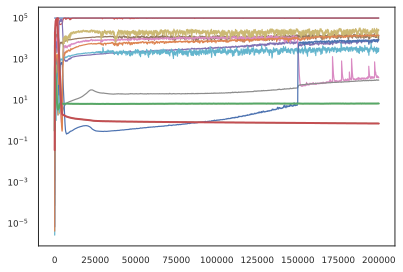

In [5]:
plt.plot(df[prior_keys].ewm(alpha=0.1).mean())
plt.plot(df[prior_keys[1]].ewm(alpha=0.1).mean(), lw=2)
plt.plot(df[prior_keys[2]].ewm(alpha=0.1).mean(), lw=2)
plt.yscale('log')

In [6]:
p.shape

(51, 200)

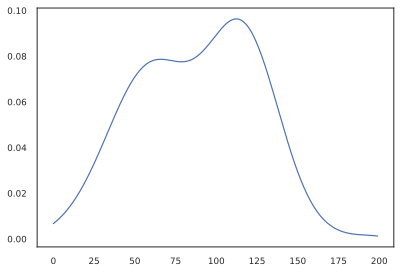

In [7]:
plt.plot(p[20])

In [8]:
def dataset(key, n_steps, n_walkers, D, v, dt, sigma0, x0):
    def initial_condition(loc, width, key, shape):
        key1, key2 = random.split(key)
        ini_1 = loc[0] + width[0] * random.normal(key1, (shape[0], int(shape[1] /2)))
        ini_2 = loc[1] + width[1] * random.normal(key2, (shape[0], int(shape[1] /2)))
        return jnp.concatenate([ini_1, ini_2], axis=1)
    
    ini = partial(initial_condition, x0, sigma0)
    locs, t = random_walk(key, ini, n_steps, n_walkers, D, v, dt=dt)
    return jnp.expand_dims(locs, -1), jnp.expand_dims(t, -1)

In [11]:
key = random.PRNGKey(42)

D = 1.5
v = 0.5
dt= 0.1
sigma0 = [1.5, 0.5]
x0=[-5, 1]
n_steps = 50
n_walkers = 200

X, t = dataset(key, n_steps, n_walkers, D, v, dt, sigma0, x0)
t+=1
X_true = np.array(dataset(key, n_steps, 100000, D, v, dt, sigma0, x0)[0])

In [12]:
X_true.shape

(51, 100000, 1)

(-10.0, 10.0)

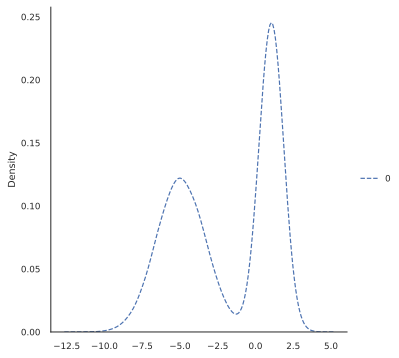

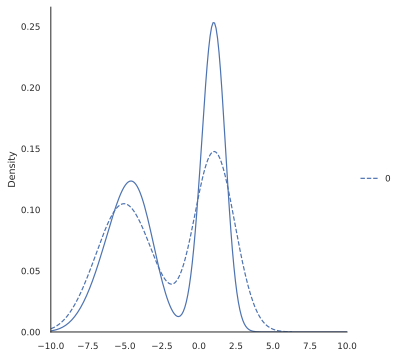

In [13]:
frame = 1

sns.displot(X_true[frame], kind='kde', color='black', linestyle='--')
sns.displot(X[frame], kind='kde', color='black', linestyle='--')
plt.plot(np.linspace(-10, 10, 200), p[frame])
plt.xlim([-10, 10])

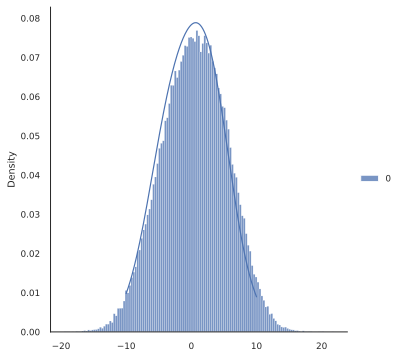

In [14]:
sns.displot(X_true[50], bins='auto', stat='density')
plt.plot(np.linspace(-10, 10, 200), p[50])

In [15]:
dens, loc = np.histogram(X_true[-1], bins=100, density=True)

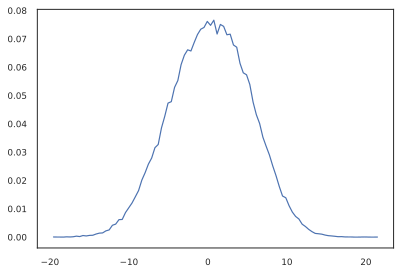

In [16]:
plt.plot(loc[:-1], dens)

In [17]:
_, loc = np.histogram(X_true[-1], bins=100, density=True)

density = []
for batch in X_true:
    density.append(np.histogram(batch, bins=loc, density=True)[0])
density = jnp.stack(density, axis=0)

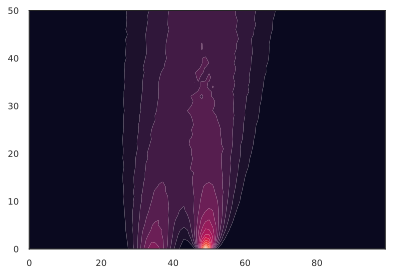

In [18]:
plt.contourf(density, 20)

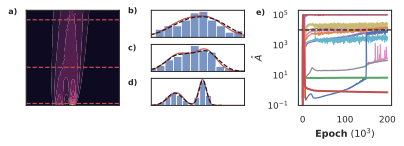

In [32]:
fig = plt.figure(constrained_layout=True, figsize=(1.0 * col_width, 0.35 * col_width))
gs = GridSpec(3, 3, figure=fig)

ax = fig.add_subplot(gs[:, 0])
ax.contourf(density, 15)
ax.set_xticks([])
ax.set_yticks([])
ax.axhline(45, color='r', linestyle='--')
ax.axhline(20, color='r', linestyle='--')
ax.axhline(1, color='r', linestyle='--')
ax.text(-19, 48, 'a)', fontdict={'weight':'bold', 'size': label_size})

ax = fig.add_subplot(gs[0, 1])
frame = 45
sns.histplot(X[frame], stat='density', ax=ax, bins='auto', legend=False)
ax.plot(np.linspace(-10, 10, 200), p[frame], color='r')
sns.kdeplot(X_true[frame].squeeze(), ax=ax, color='k', linestyle='--')
ax.set_xlim([-10, 10])
ax.set_ylabel('')
ax.set_xticks([])
ax.text(-15, 0.09, 'b)', fontdict={'weight':'bold', 'size': label_size})
ax.set_yticks([])

ax = fig.add_subplot(gs[1, 1])
frame = 20
sns.histplot(X[frame], stat='density', ax=ax, bins='auto', legend=False)
ax.plot(np.linspace(-10, 10, 200), p[frame], color='r')
sns.kdeplot(X_true[frame].squeeze(), ax=ax, color='k', linestyle='--')
ax.set_xlim([-10, 10])
ax.set_ylabel('')
ax.set_xticks([])
ax.text(-15, 0.09, 'c)', fontdict={'weight':'bold', 'size': label_size})
ax.set_yticks([])

ax = fig.add_subplot(gs[2, 1])
frame = 1
sns.histplot(X[frame], stat='density', ax=ax, bins='auto', legend=False)
ax.plot(np.linspace(-10, 10, 200), p[frame], color='r')
sns.kdeplot(X_true[frame].squeeze(), ax=ax, color='k', linestyle='--')
ax.set_xlim([-10, 10])
ax.set_ylabel('')
ax.text(-15, 0.2, 'd)', fontdict={'weight':'bold', 'size': label_size})
ax.set_yticks([])
ax.set_xticks([])

ax = fig.add_subplot(gs[:, 2])
ax.plot(df[prior_keys].ewm(alpha=0.1).mean())
ax.plot(df[prior_keys[1]].ewm(alpha=0.1).mean(), lw=2)
ax.plot(df[prior_keys[2]].ewm(alpha=0.1).mean(), lw=2)
ax.set_yscale('log')
ax.set_ylim([1e-1, 2e5])
ax.axhline(1e4, color='k', linestyle='--')
ax.set_ylabel(r'$\hat{A}$')
ax.text(-110000.0, 1e5, 'e)', fontdict={'weight':'bold', 'size': label_size})
ax.set_xlabel(r'$\mathbf{Epoch}$ ($10^3$)')
ax.set_xticks([0, 100000, 200000])
ax.set_xticklabels([0, 100, 200])

plt.savefig('NF.pdf', pad_inches=0, bbox_inches='tight')

<AxesSubplot:ylabel='Density'>

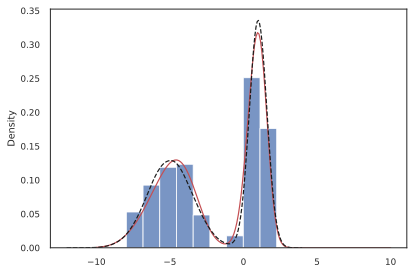

In [34]:
frame = 0
sns.histplot(X[frame], stat='density', bins='auto', legend=False)
plt.plot(np.linspace(-10, 10, 200), p[frame], color='r')
sns.kdeplot(X_true[frame].squeeze(), color='k', linestyle='--')
